# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

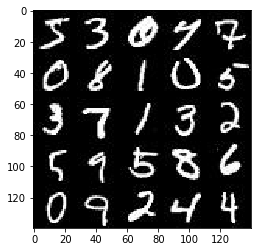

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

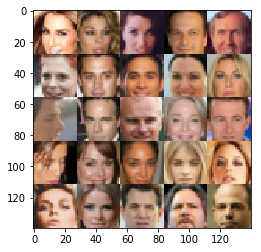

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_r = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learn_rate = tf.placeholder(tf.float32, (None))

    return input_r, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def conv2d(inputs, depth, kernel_size, strides, padding, stddev=0.02):
    return tf.layers.conv2d(
        inputs, depth, kernel_size, strides, padding,
        activation=None, kernel_initializer=tf.random_normal_initializer(stddev=stddev))


def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope("discriminator", reuse=reuse):
        #28x28x3
        conv_1 = conv2d(images, 64, 5, 2, "same")
        relu_1 = tf.maximum(alpha*conv_1, conv_1)

        #14x14x64
        conv_2 = conv2d(relu_1, 128, 5, 2, "same")
        norm_2 = tf.layers.batch_normalization(conv_2, training=True)
        relu_2 = tf.maximum(alpha*norm_2, norm_2)

        #7x7x128
        conv_3 = conv2d(relu_2, 256, 5, 2, "same")
        norm_3 = tf.layers.batch_normalization(conv_3, training=True)
        relu_3 = tf.maximum(alpha*norm_3, norm_3)

        #4x4x256
        flat_4 = tf.reshape(relu_3, (-1, 4*4*256))
        logits = tf.layers.dense(flat_4, 1, activation=None)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def conv2d_transpose(inputs, depth, kernel_size, strides, padding, stddev=0.02):
    return tf.layers.conv2d_transpose(
        inputs, depth, kernel_size, strides, padding, 
        activation=None, kernel_initializer=tf.random_normal_initializer(stddev=stddev))

def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope("generator", reuse=not is_train):
        full_1 = tf.layers.dense(z, 3*3*512, activation=None)
        conv_1 = tf.reshape(full_1, (-1, 3, 3, 512))
        norm_1 = tf.layers.batch_normalization(conv_1, training=is_train)
        relu_1 = tf.maximum(alpha*norm_1, norm_1)
        
        #3x3x512
        conv_2 = conv2d_transpose(relu_1, 256, 5, 2, "same")
        norm_2 = tf.layers.batch_normalization(conv_2, training=is_train)
        relu_2 = tf.maximum(alpha*norm_2, norm_2)
        
        #6x6x256
        conv_3 = conv2d_transpose(relu_2, 128, 5, 2, "same")
        norm_3 = tf.layers.batch_normalization(conv_3, training=is_train)
        relu_3 = tf.maximum(alpha*norm_3, norm_3)
        
        #12x12x128
        logits = conv2d_transpose(relu_3, out_channel_dim, 6, 2, "valid")
        
        #28x28x64
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    input_fake = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    
    _, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    _, d_logits_fake = discriminator(input_fake, reuse=True, alpha=alpha)
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith("discriminator")]
    g_vars = [v for v in t_vars if v.name.startswith("generator")]
    
    d_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    _, image_width, image_height, image_channels = data_shape
    input_r, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_r, input_z, image_channels)
    d_train, g_train = model_opt(d_loss, g_loss, learning_rate=learn_rate, beta1=beta1)
    
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        step = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    d_train, feed_dict={input_r: batch_images*2, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(
                    g_train, feed_dict={input_z: batch_z, learn_rate: learning_rate})
                
                if step % 10 == 0:
                    d_loss_train = d_loss.eval({input_r: batch_images*2, input_z: batch_z})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    print("Epoch: {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator loss: {:.4f}...".format(d_loss_train), 
                          "Generator loss: {:.4f}".format(g_loss_train))
                
                if step % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2... Discriminator loss: 0.4327... Generator loss: 1.5390
Epoch: 1/2... Discriminator loss: 0.4379... Generator loss: 1.2625
Epoch: 1/2... Discriminator loss: 1.3163... Generator loss: 6.2878
Epoch: 1/2... Discriminator loss: 1.1987... Generator loss: 4.2839
Epoch: 1/2... Discriminator loss: 1.1399... Generator loss: 0.5874
Epoch: 1/2... Discriminator loss: 0.4938... Generator loss: 3.3539
Epoch: 1/2... Discriminator loss: 0.4958... Generator loss: 1.8081
Epoch: 1/2... Discriminator loss: 0.5674... Generator loss: 1.9332
Epoch: 1/2... Discriminator loss: 0.3498... Generator loss: 1.9407
Epoch: 1/2... Discriminator loss: 0.5520... Generator loss: 1.8013


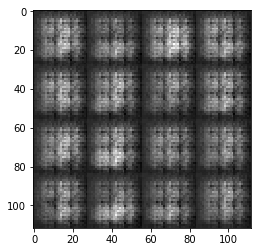

Epoch: 1/2... Discriminator loss: 0.4045... Generator loss: 2.6955
Epoch: 1/2... Discriminator loss: 0.3278... Generator loss: 2.3528
Epoch: 1/2... Discriminator loss: 0.3460... Generator loss: 2.2644
Epoch: 1/2... Discriminator loss: 0.4911... Generator loss: 1.3934
Epoch: 1/2... Discriminator loss: 0.4629... Generator loss: 1.7573
Epoch: 1/2... Discriminator loss: 0.4433... Generator loss: 1.8866
Epoch: 1/2... Discriminator loss: 0.2729... Generator loss: 2.4162
Epoch: 1/2... Discriminator loss: 0.3498... Generator loss: 2.1430
Epoch: 1/2... Discriminator loss: 0.2951... Generator loss: 2.2950
Epoch: 1/2... Discriminator loss: 0.2533... Generator loss: 3.4584


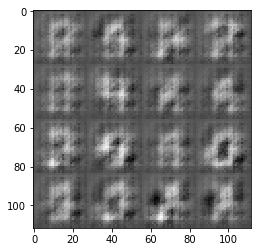

Epoch: 1/2... Discriminator loss: 0.6501... Generator loss: 0.9904
Epoch: 1/2... Discriminator loss: 0.5682... Generator loss: 1.3761
Epoch: 1/2... Discriminator loss: 0.4067... Generator loss: 2.1191
Epoch: 1/2... Discriminator loss: 0.5212... Generator loss: 1.9316
Epoch: 1/2... Discriminator loss: 0.3328... Generator loss: 2.5232
Epoch: 1/2... Discriminator loss: 0.9535... Generator loss: 2.7997
Epoch: 1/2... Discriminator loss: 0.4959... Generator loss: 1.8780
Epoch: 1/2... Discriminator loss: 0.8077... Generator loss: 1.0900
Epoch: 1/2... Discriminator loss: 0.6356... Generator loss: 1.5907
Epoch: 1/2... Discriminator loss: 0.6679... Generator loss: 2.0034


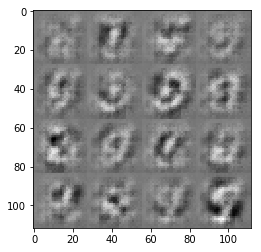

Epoch: 1/2... Discriminator loss: 0.8349... Generator loss: 0.9586
Epoch: 1/2... Discriminator loss: 0.5288... Generator loss: 2.0686
Epoch: 1/2... Discriminator loss: 0.5280... Generator loss: 1.8650
Epoch: 1/2... Discriminator loss: 0.7427... Generator loss: 1.6409
Epoch: 1/2... Discriminator loss: 0.6303... Generator loss: 1.8647
Epoch: 1/2... Discriminator loss: 0.4003... Generator loss: 2.0971
Epoch: 1/2... Discriminator loss: 0.6305... Generator loss: 1.9781
Epoch: 1/2... Discriminator loss: 0.6766... Generator loss: 1.4470
Epoch: 1/2... Discriminator loss: 0.8463... Generator loss: 2.6571
Epoch: 1/2... Discriminator loss: 0.7689... Generator loss: 1.2998


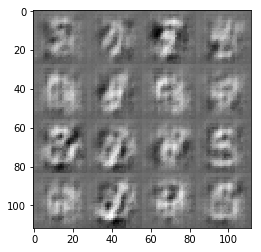

Epoch: 1/2... Discriminator loss: 0.8782... Generator loss: 2.2156
Epoch: 1/2... Discriminator loss: 0.7951... Generator loss: 1.0108
Epoch: 1/2... Discriminator loss: 0.4571... Generator loss: 2.0718
Epoch: 1/2... Discriminator loss: 0.5141... Generator loss: 1.9914
Epoch: 1/2... Discriminator loss: 0.4642... Generator loss: 2.5512
Epoch: 1/2... Discriminator loss: 0.4658... Generator loss: 1.9578
Epoch: 2/2... Discriminator loss: 0.5023... Generator loss: 1.6385
Epoch: 2/2... Discriminator loss: 0.8608... Generator loss: 2.6233
Epoch: 2/2... Discriminator loss: 0.5828... Generator loss: 1.9987
Epoch: 2/2... Discriminator loss: 0.6020... Generator loss: 1.2338


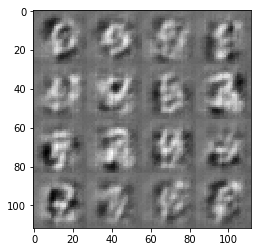

Epoch: 2/2... Discriminator loss: 0.5618... Generator loss: 1.6100
Epoch: 2/2... Discriminator loss: 0.5116... Generator loss: 1.4759
Epoch: 2/2... Discriminator loss: 0.7705... Generator loss: 0.9379
Epoch: 2/2... Discriminator loss: 1.0327... Generator loss: 0.6092
Epoch: 2/2... Discriminator loss: 0.4447... Generator loss: 2.2828
Epoch: 2/2... Discriminator loss: 0.4969... Generator loss: 1.7812
Epoch: 2/2... Discriminator loss: 0.5881... Generator loss: 1.2391
Epoch: 2/2... Discriminator loss: 0.5973... Generator loss: 2.3789
Epoch: 2/2... Discriminator loss: 0.6145... Generator loss: 1.3359
Epoch: 2/2... Discriminator loss: 0.4992... Generator loss: 1.9129


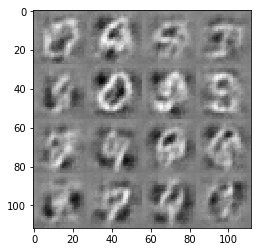

Epoch: 2/2... Discriminator loss: 0.4988... Generator loss: 1.5994
Epoch: 2/2... Discriminator loss: 0.4676... Generator loss: 1.5122
Epoch: 2/2... Discriminator loss: 0.9055... Generator loss: 0.8251
Epoch: 2/2... Discriminator loss: 0.6334... Generator loss: 1.2174
Epoch: 2/2... Discriminator loss: 0.6028... Generator loss: 1.9919
Epoch: 2/2... Discriminator loss: 0.6758... Generator loss: 2.5432
Epoch: 2/2... Discriminator loss: 0.4882... Generator loss: 1.7873
Epoch: 2/2... Discriminator loss: 0.8902... Generator loss: 0.8300
Epoch: 2/2... Discriminator loss: 0.5047... Generator loss: 1.8525
Epoch: 2/2... Discriminator loss: 0.5750... Generator loss: 1.6929


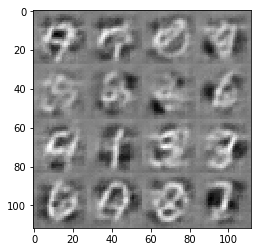

Epoch: 2/2... Discriminator loss: 0.5822... Generator loss: 1.2293
Epoch: 2/2... Discriminator loss: 0.6399... Generator loss: 1.4240
Epoch: 2/2... Discriminator loss: 0.6724... Generator loss: 1.6443
Epoch: 2/2... Discriminator loss: 0.6279... Generator loss: 1.5958
Epoch: 2/2... Discriminator loss: 0.6172... Generator loss: 1.3452
Epoch: 2/2... Discriminator loss: 0.5523... Generator loss: 1.4869
Epoch: 2/2... Discriminator loss: 0.7232... Generator loss: 1.0762
Epoch: 2/2... Discriminator loss: 0.7655... Generator loss: 2.2540
Epoch: 2/2... Discriminator loss: 0.6670... Generator loss: 1.8214
Epoch: 2/2... Discriminator loss: 0.9706... Generator loss: 2.6340


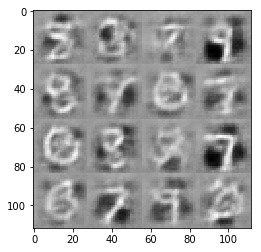

Epoch: 2/2... Discriminator loss: 0.6211... Generator loss: 1.4949
Epoch: 2/2... Discriminator loss: 0.6682... Generator loss: 2.2531
Epoch: 2/2... Discriminator loss: 0.6275... Generator loss: 1.1656
Epoch: 2/2... Discriminator loss: 0.5186... Generator loss: 1.7517
Epoch: 2/2... Discriminator loss: 0.9614... Generator loss: 0.6458
Epoch: 2/2... Discriminator loss: 0.7625... Generator loss: 1.0673
Epoch: 2/2... Discriminator loss: 0.6816... Generator loss: 1.7769
Epoch: 2/2... Discriminator loss: 0.6089... Generator loss: 2.1285
Epoch: 2/2... Discriminator loss: 1.3922... Generator loss: 3.4334
Epoch: 2/2... Discriminator loss: 0.8128... Generator loss: 1.1067


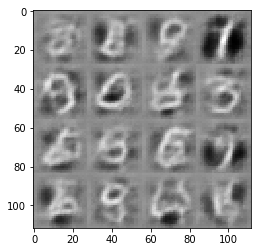

Epoch: 2/2... Discriminator loss: 0.9604... Generator loss: 0.8553
Epoch: 2/2... Discriminator loss: 0.6895... Generator loss: 1.4557
Epoch: 2/2... Discriminator loss: 0.5077... Generator loss: 1.5533


In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1... Discriminator loss: 0.7307... Generator loss: 1.2810
Epoch: 1/1... Discriminator loss: 0.3780... Generator loss: 1.6329
Epoch: 1/1... Discriminator loss: 0.3583... Generator loss: 1.6288
Epoch: 1/1... Discriminator loss: 0.1757... Generator loss: 2.7188
Epoch: 1/1... Discriminator loss: 0.2601... Generator loss: 6.2805
Epoch: 1/1... Discriminator loss: 0.0891... Generator loss: 7.1045
Epoch: 1/1... Discriminator loss: 0.2523... Generator loss: 4.9955
Epoch: 1/1... Discriminator loss: 1.0165... Generator loss: 0.7329
Epoch: 1/1... Discriminator loss: 0.6083... Generator loss: 1.8956
Epoch: 1/1... Discriminator loss: 0.4766... Generator loss: 1.5359


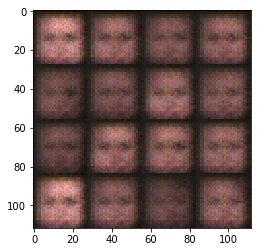

Epoch: 1/1... Discriminator loss: 0.8458... Generator loss: 0.6728
Epoch: 1/1... Discriminator loss: 0.5296... Generator loss: 1.1488
Epoch: 1/1... Discriminator loss: 0.4214... Generator loss: 1.8298
Epoch: 1/1... Discriminator loss: 0.4444... Generator loss: 2.7434
Epoch: 1/1... Discriminator loss: 0.7832... Generator loss: 0.8885
Epoch: 1/1... Discriminator loss: 0.4963... Generator loss: 1.7632
Epoch: 1/1... Discriminator loss: 0.5781... Generator loss: 1.3509
Epoch: 1/1... Discriminator loss: 1.0104... Generator loss: 0.7137
Epoch: 1/1... Discriminator loss: 0.6094... Generator loss: 1.4727
Epoch: 1/1... Discriminator loss: 0.8745... Generator loss: 0.8138


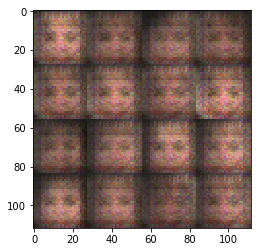

Epoch: 1/1... Discriminator loss: 0.8973... Generator loss: 0.8626
Epoch: 1/1... Discriminator loss: 0.7171... Generator loss: 1.0678
Epoch: 1/1... Discriminator loss: 0.8824... Generator loss: 1.1504
Epoch: 1/1... Discriminator loss: 0.6751... Generator loss: 2.2494
Epoch: 1/1... Discriminator loss: 0.9439... Generator loss: 1.8594
Epoch: 1/1... Discriminator loss: 0.6027... Generator loss: 1.3686
Epoch: 1/1... Discriminator loss: 0.5248... Generator loss: 1.5426
Epoch: 1/1... Discriminator loss: 0.7134... Generator loss: 1.0631
Epoch: 1/1... Discriminator loss: 1.2785... Generator loss: 0.5121
Epoch: 1/1... Discriminator loss: 0.5482... Generator loss: 1.6694


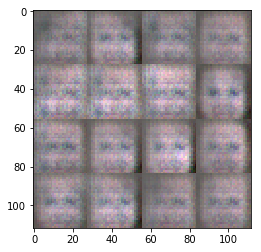

Epoch: 1/1... Discriminator loss: 1.0327... Generator loss: 2.8311
Epoch: 1/1... Discriminator loss: 0.8932... Generator loss: 1.0034
Epoch: 1/1... Discriminator loss: 0.4692... Generator loss: 1.5289
Epoch: 1/1... Discriminator loss: 0.3317... Generator loss: 2.2555
Epoch: 1/1... Discriminator loss: 3.3896... Generator loss: 7.7131
Epoch: 1/1... Discriminator loss: 0.4887... Generator loss: 1.6148
Epoch: 1/1... Discriminator loss: 0.7939... Generator loss: 1.2694
Epoch: 1/1... Discriminator loss: 0.6090... Generator loss: 1.4442
Epoch: 1/1... Discriminator loss: 0.9459... Generator loss: 2.3554
Epoch: 1/1... Discriminator loss: 0.9208... Generator loss: 2.7049


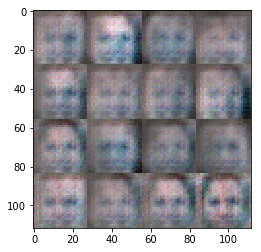

Epoch: 1/1... Discriminator loss: 0.6648... Generator loss: 1.5975
Epoch: 1/1... Discriminator loss: 0.6968... Generator loss: 1.4355
Epoch: 1/1... Discriminator loss: 0.9622... Generator loss: 0.9077
Epoch: 1/1... Discriminator loss: 0.7160... Generator loss: 1.4314
Epoch: 1/1... Discriminator loss: 0.9505... Generator loss: 2.3761
Epoch: 1/1... Discriminator loss: 0.7839... Generator loss: 0.8698
Epoch: 1/1... Discriminator loss: 0.5176... Generator loss: 1.6331
Epoch: 1/1... Discriminator loss: 0.7567... Generator loss: 1.4115
Epoch: 1/1... Discriminator loss: 0.3070... Generator loss: 2.3771
Epoch: 1/1... Discriminator loss: 0.7313... Generator loss: 2.6412


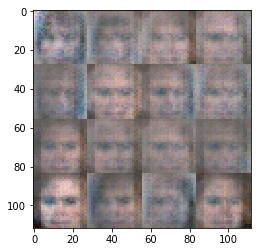

Epoch: 1/1... Discriminator loss: 0.9071... Generator loss: 2.1263
Epoch: 1/1... Discriminator loss: 0.7301... Generator loss: 1.2422
Epoch: 1/1... Discriminator loss: 0.7323... Generator loss: 0.9450
Epoch: 1/1... Discriminator loss: 0.3504... Generator loss: 2.1973
Epoch: 1/1... Discriminator loss: 0.5558... Generator loss: 1.5547
Epoch: 1/1... Discriminator loss: 0.6067... Generator loss: 1.4686
Epoch: 1/1... Discriminator loss: 0.4845... Generator loss: 1.7648
Epoch: 1/1... Discriminator loss: 0.6805... Generator loss: 1.2388
Epoch: 1/1... Discriminator loss: 0.6638... Generator loss: 1.4930
Epoch: 1/1... Discriminator loss: 0.4979... Generator loss: 2.2579


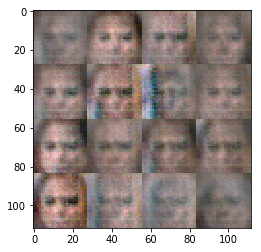

Epoch: 1/1... Discriminator loss: 0.6620... Generator loss: 1.2541
Epoch: 1/1... Discriminator loss: 0.3942... Generator loss: 1.7804
Epoch: 1/1... Discriminator loss: 0.7281... Generator loss: 1.0591
Epoch: 1/1... Discriminator loss: 0.4090... Generator loss: 1.7950
Epoch: 1/1... Discriminator loss: 0.5811... Generator loss: 2.5949
Epoch: 1/1... Discriminator loss: 0.8802... Generator loss: 1.0719
Epoch: 1/1... Discriminator loss: 0.5771... Generator loss: 1.6276
Epoch: 1/1... Discriminator loss: 0.4615... Generator loss: 1.5687
Epoch: 1/1... Discriminator loss: 0.8523... Generator loss: 0.7653
Epoch: 1/1... Discriminator loss: 0.6827... Generator loss: 1.0483


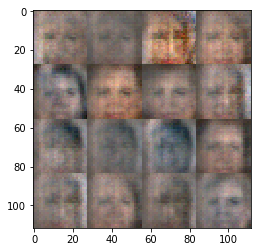

Epoch: 1/1... Discriminator loss: 0.7771... Generator loss: 0.9175
Epoch: 1/1... Discriminator loss: 0.4986... Generator loss: 1.9585
Epoch: 1/1... Discriminator loss: 0.5664... Generator loss: 1.6375
Epoch: 1/1... Discriminator loss: 0.6093... Generator loss: 1.6421
Epoch: 1/1... Discriminator loss: 0.7962... Generator loss: 1.0098
Epoch: 1/1... Discriminator loss: 0.7211... Generator loss: 1.6920
Epoch: 1/1... Discriminator loss: 0.9476... Generator loss: 1.0378
Epoch: 1/1... Discriminator loss: 1.1293... Generator loss: 2.9605
Epoch: 1/1... Discriminator loss: 0.6838... Generator loss: 1.8978
Epoch: 1/1... Discriminator loss: 1.2817... Generator loss: 0.4872


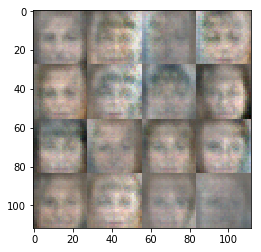

Epoch: 1/1... Discriminator loss: 0.9536... Generator loss: 0.9216
Epoch: 1/1... Discriminator loss: 0.6525... Generator loss: 1.7757
Epoch: 1/1... Discriminator loss: 2.0106... Generator loss: 3.7793
Epoch: 1/1... Discriminator loss: 0.8761... Generator loss: 2.6626
Epoch: 1/1... Discriminator loss: 0.7149... Generator loss: 1.3554
Epoch: 1/1... Discriminator loss: 0.7873... Generator loss: 2.3149
Epoch: 1/1... Discriminator loss: 0.9214... Generator loss: 1.7713
Epoch: 1/1... Discriminator loss: 0.8469... Generator loss: 1.8117
Epoch: 1/1... Discriminator loss: 1.3674... Generator loss: 0.4082
Epoch: 1/1... Discriminator loss: 0.7265... Generator loss: 1.0680


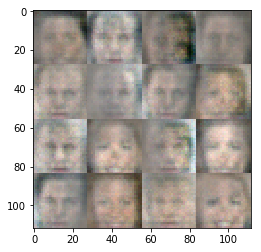

Epoch: 1/1... Discriminator loss: 0.8443... Generator loss: 1.2835
Epoch: 1/1... Discriminator loss: 0.7925... Generator loss: 1.7616
Epoch: 1/1... Discriminator loss: 0.7537... Generator loss: 1.5011
Epoch: 1/1... Discriminator loss: 0.9206... Generator loss: 2.2830
Epoch: 1/1... Discriminator loss: 0.6889... Generator loss: 1.2149
Epoch: 1/1... Discriminator loss: 0.4410... Generator loss: 1.7841
Epoch: 1/1... Discriminator loss: 0.5703... Generator loss: 2.0267


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.